# Импорт библиотек

In [ ]:
#! git clone --recursive https://github.com/Microsoft/LightGBM
#! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

In [ ]:
#!pip install catboost
#!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import gc

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, \
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix, \
    classification_report, roc_curve, auc, precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier

from scipy import stats
from tqdm import tqdm_notebook
from typing import Tuple, List

import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from catboost import Pool

import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

RAND = 25
N_FOLDS = 5

Mounted at /content/drive


# Загрузка данных

In [ ]:
train_df = pd.read_feather('/content/drive/MyDrive/Colab Notebooks/Pet project/train_data_prep.ftr')
train_df.head()

,customer_ID,D_63_count,D_63_last,D_63_nunique,D_64_count,D_64_last,D_64_nunique,D_68_count,D_68_last,D_68_nunique,...,D_131_diff,D_133_diff,R_28_diff,D_139_diff,D_140_diff,D_141_diff,D_143_diff,D_144_diff,D_145_diff,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13,2,1,13,2,1,13,6,1,...,0.325439,50.031250,-0.648438,3.597656,1.142578,0.979004,4.289062,-0.532227,1.029297,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13,1,1,13,2,1,13,6,1,...,0.117126,-0.687500,-0.718750,-0.552246,0.616699,0.632812,-0.603027,0.253418,1.375000,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,13,1,1,13,3,1,13,6,1,...,5.792969,3.992188,0.507812,-0.089844,-0.306152,-0.709961,-0.539551,-0.886230,-0.385254,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,13,1,1,13,2,1,13,3,3,...,-0.455078,0.545410,8.109375,-0.709473,-0.107361,0.314209,-0.170776,0.153564,-0.564453,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,13,1,1,13,2,1,13,6,1,...,0.481689,0.914551,0.534668,0.533691,0.409668,-0.208130,0.638184,0.097717,-0.560547,0


# Метрика для Amex

[Ссылка на метрику](https://www.kaggle.com/code/inversion/amex-competition-metric-python)

In [ ]:
def amex_metric(y_true: np.array, y_pred: np.array) -> float:
    '''
    Метрика AMEX расчитывается для действительного значения класса и 
    предсказанной вероятности класса .

    Параметры:
        y_true (np.array): действительное значение класса
        y_pred (np.array): предсказание вероятности класса
    Возвращаемое значение:
        result (float): значение метрики amex
    '''

    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:, 0] == 0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:, 0]) / np.sum(labels[:, 0])
    gini = [0, 0]
    
    for i in [1, 0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:, 0] == 0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] * weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    
    result = 0.5 * (gini[1] / gini[0] + top_four)
    return result

In [ ]:
def get_metrics(y_test: np.array, y_pred: np.array, y_score: np.array,
                name: str) -> pd.DataFrame:
    '''
    Возвращает датафрейм с метриками для предсказанных значений моделью.
    Используемые метрики: Accuracy, ROC_AUC, Precision, F1, Logloss, AMEX.

    Параметры:
        y_test (np.array): действительное значение класса
        y_pred (np.array): предсказание класса
        y_score (np.array): предсказание вероятности класса
    Возвращаемое значение:
        df_metrics (pd.DataFrame): датафрейм с метриками
    '''

    df_metrics = pd.DataFrame()
    df_metrics['model'] = [name]
    df_metrics['Accuracy'] = [accuracy_score(y_test, y_pred)]
    df_metrics['ROC_AUC'] = [roc_auc_score(y_test, y_score)]
    df_metrics['Precision'] = [precision_score(y_test, y_pred)]
    df_metrics['Recall'] = [recall_score(y_test, y_pred)]
    df_metrics['f1'] = [f1_score(y_test, y_pred)]
    df_metrics['Logloss'] = [log_loss(y_test, y_score)]
    df_metrics['AMEX'] = amex_metric(y_test, y_score)
    
    return df_metrics

# Baseline

In [ ]:
X = train_df.drop(['customer_ID', 'target'], axis=1)
y = train_df['target']

# Категориальные столбцы
cat_features = train_df.select_dtypes(include=['category']).columns.to_list()

# Подготовка данных для бинаризованного датафрейма
transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_features), remainder='passthrough')
transformed = transformer.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=RAND)

## Lightgbm

In [ ]:
def lgb_amex_metric(y_true: np.array, y_pred: np.array) ->\
                                                 Tuple[str, float, bool]:
    """
    Amex метрика для Lightgbm.

    Параметры:
        y_true (np.array): действительное значение класса
        y_pred (np.array): предсказание вероятности класса
    Возвращаемое значение:
        _ (Tuple[str, float, bool]): название метрики; 
            значение метрики; чем больше, тем лучше
    """

    return 'amex_metric', amex_metric(y_true, y_pred), True

In [ ]:
gbm = LGBMClassifier(random_state=RAND,
                     is_unbalance=True,
                     device='gpu',
                     early_stopping_round=200,
                     verbose=-1)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric=lgb_amex_metric)

preds_test = gbm.predict(X_test)
preds_prob_test = gbm.predict_proba(X_test)[:, 1]
preds_train = gbm.predict(X_train)
preds_prob_train = gbm.predict_proba(X_train)[:, 1]

metric_df = get_metrics(y_test, preds_test, preds_prob_test, 'Lightgbm Base')
metric_df.style.highlight_max(color='yellowgreen', subset='AMEX')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,AMEX
0,Lightgbm Base,0.878540,0.957980,0.702367,0.921358,0.797095,0.265844,0.777343


In [ ]:
def check_overfitting(y_pred_train: np.array, y_score_train: np.array, 
                      y_pred_test: np.array, y_score_test: np.array,
                      y_test: pd.Series, y_train: pd.Series) -> None:
    """
    Проверка модели на переобучение(overfitting). Функция выводин значения 
    метрик(F1, Recall, Amex) для тестового и тренировочного набора данных.

    Параметры:
        y_pred_train (np.array): предсказание значение класса на тренировочных 
                                    данных
        y_score_train (np.array): предсказание вероятности класса на 
                                    тренировочных данных
        y_pred_test (np.array): предсказание значение класса на тестовых 
                                    данных
        y_score_test (np.array): предсказание вероятности класса на тестовых 
                                    данных
        y_test (pd.Series): действительное значение класса на тестовых данных
        y_train (pd.Series): действительное значение класса на тренировочных 
                                    данных
    """

    print('Проверка на overfitting')
    print('-' * 20)
    print(f'F1 score train: {f1_score(y_train, y_pred_train):.3f}')
    print(f'F1 score test: {f1_score(y_test, y_pred_test):.3f}')
    print('-' * 20)
    print(f'Recall score train: {recall_score(y_train, y_pred_train):.3f}')
    print(f'Recall score test: {recall_score(y_test, y_pred_test):.3f}')
    print('-' * 20)
    print(f'Amex score train: {amex_metric(y_train, y_score_train):.3f}')
    print(f'Amex score test: {amex_metric(y_test, y_score_test):.3f}')

In [ ]:
check_overfitting(preds_train, preds_prob_train, preds_test, preds_prob_test, 
                  y_test, y_train)

Проверка на overfitting
--------------------
F1 score train: 0.805
F1 score test: 0.797
--------------------
Recall score train: 0.929
Recall score test: 0.921
--------------------
Amex score train: 0.794
Amex score test: 0.777


### Важность признаков для Lightgbm




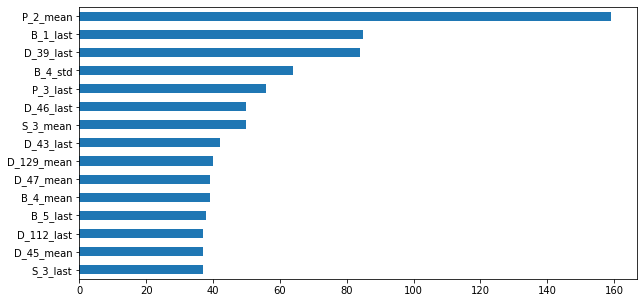

In [ ]:
feature_imp = pd.Series(gbm.feature_importances_, index=X.columns)
feature_imp.nlargest(15).sort_values(ascending=True).plot(kind='barh',
                                                          figsize=(10, 5))

## LGBM + CV

In [ ]:
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts = np.empty(N_FOLDS)
preds_lst = []
preds_prob_lst = []
models_ls = []

for idx, (train_idx,
          valid_idx) in tqdm_notebook(enumerate(cv.split(X_train, y_train)),
                                      total=N_FOLDS):
    X_train_, X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_train_, y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    model = LGBMClassifier(random_state=RAND,
                           is_unbalance=True,
                           device='gpu',
                           early_stopping_round=200,
                           verbose=-1)
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_valid, y_valid)],
              eval_metric=lgb_amex_metric)

    models_ls.append(model)
    preds_lst.append(model.predict(X_test))
    preds_prob_lst.append(model.predict_proba(X_test)[:, 1])

metric_df = pd.concat([
    metric_df,
    get_metrics(y_test,
                stats.mode(preds_lst)[0][0], np.mean(preds_prob_lst, axis=0),
                'LGBM + 5CV')
], ignore_index=True)

metric_df.style.highlight_max(color='yellowgreen', subset='AMEX')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/5 [00:00<?, ?it/s]

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,AMEX
0,Lightgbm Base,0.878540,0.957980,0.702367,0.921358,0.797095,0.265844,0.777343
1,LGBM + 5CV,0.878986,0.958443,0.703645,0.920222,0.797491,0.264077,0.780079


In [ ]:
def cv_predict(models, X_train: pd.DataFrame, X_test: pd.DataFrame) -> list:
    """
    Вычисление предсказанных значений и вероятностей классов на тестовой и 
    тренировочной выборки.

    Параметры:
        models: модель для предсказания значений
        X_train (pd.DataFrame): тренировочные данные
        X_test (pd.DataFrame): тестовые данные
    Возвращаемое значение:
        _ (list): список из 2-х элементов, для тестовых и тренировочных данных.
            Каждый элемент списка содержит предсказанное значение и вероятность 
            класса.
    """

    result = []
    for X_lc in (X_train, X_test):
        preds_lst = []
        preds_prob_lst = []
        for md in models:
            preds_lst.append(model.predict(X_lc))
            preds_prob_lst.append(model.predict_proba(X_lc)[:, 1])
        result.append(
            (stats.mode(preds_lst)[0][0], np.mean(preds_prob_lst, axis=0)))
    return result


preds_train, preds_test = cv_predict(models_ls, X_train, X_test)
check_overfitting(*preds_train, *preds_test, y_test, y_train)

Проверка на overfitting
--------------------
F1 score train: 0.805
F1 score test: 0.797
--------------------
Recall score train: 0.929
Recall score test: 0.920
--------------------
Amex score train: 0.793
Amex score test: 0.777


## LGBM + Optuna

In [ ]:
def objective(trial):
    param_grid = {
        "device_type":
        trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators":
        trial.suggest_categorical("n_estimators", [1000, 3000]),
        "learning_rate":
        trial.suggest_float("learning_rate", 0.001, 0.5),
        "num_leaves":
        trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth":
        trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf":
        trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin":
        trial.suggest_int("max_bin", 100, 250),
        "lambda_l1":
        trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2":
        trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split":
        trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction":
        trial.suggest_float("bagging_fraction", 0.2, 0.9, step=0.1),
        "bagging_freq":
        trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction":
        trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1),
        "early_stopping_round": 200,
        'is_unbalance': True,
        'verbose': -1,
        'random_state': RAND
    }

    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
    cv_predicts = np.empty(N_FOLDS)

    for idx, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train)):
        X_train_, X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_, y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = LGBMClassifier(**param_grid)
        model.fit(
            X_train_,
            y_train_,
            eval_set=[(X_valid, y_valid)],
            eval_metric=lgb_amex_metric
        )

        preds_prob = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = amex_metric(y_test, preds_prob)

    return np.mean(cv_predicts)


study_lgb = optuna.create_study(direction="maximize",
                                study_name="LGBM Classifier")
func = lambda trial: objective(trial)
study_lgb.optimize(func, n_trials=15)

[I 2022-09-18 17:11:39,179] A new study created in memory with name: LGBM Classifier
[I 2022-09-18 17:17:36,282] Trial 0 finished with value: 0.7767764390938425 and parameters: {'device_type': 'gpu', 'n_estimators': 3000, 'learning_rate': 0.31288001313979796, 'num_leaves': 2880, 'max_depth': 7, 'min_data_in_leaf': 9100, 'max_bin': 154, 'lambda_l1': 5, 'lambda_l2': 65, 'min_gain_to_split': 7.594274542172289, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 0.7767764390938425.
[I 2022-09-18 17:24:57,347] Trial 1 finished with value: 0.7767411191085378 and parameters: {'device_type': 'gpu', 'n_estimators': 1000, 'learning_rate': 0.11529801904237887, 'num_leaves': 740, 'max_depth': 5, 'min_data_in_leaf': 6600, 'max_bin': 111, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 2.51049684844066, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.7767764390938425.
[I 2022-09-1

In [ ]:
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts = np.empty(N_FOLDS)
preds_lst = []
preds_prob_lst = []
models_ls = []

for idx, (train_idx, valid_idx) in tqdm_notebook(enumerate(cv.split(X_train, y_train)), total=N_FOLDS):
    X_train_, X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_train_, y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    model = LGBMClassifier(**study_lgb.best_params, 
                           random_state=RAND, verbose=-1, is_unbalance=True, early_stopping_round=200)
    model.fit(X_train_,
                y_train_,
                eval_set=[(X_valid, y_valid)],
                eval_metric=lgb_amex_metric
              )
    models_ls.append(model)
    # Предсказание
    preds_lst.append(model.predict(X_test))
    preds_prob_lst.append(model.predict_proba(X_test)[:, 1])


# Получение метрики
metric_df = pd.concat([metric_df, get_metrics(
    y_test, stats.mode(preds_lst)[0][0], 
    np.mean(preds_prob_lst, axis=0), 
    'LGBM_CV + Optuna')
], ignore_index=True)
metric_df.style.highlight_max(color='yellowgreen', subset='AMEX')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/5 [00:00<?, ?it/s]

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,AMEX
0,Lightgbm Base,0.878540,0.957980,0.702367,0.921358,0.797095,0.265844,0.777343
1,LGBM + 5CV,0.878986,0.958443,0.703645,0.920222,0.797491,0.264077,0.780079
2,LGBM_CV + Optuna,0.881176,0.959166,0.708482,0.919423,0.800286,0.261746,0.782274


In [ ]:
preds_train, preds_test = cv_predict(models_ls, X_train, X_test)
check_overfitting(*preds_train, *preds_test, y_test, y_train)

Проверка на overfitting
--------------------
F1 score train: 0.806
F1 score test: 0.798
--------------------
Recall score train: 0.928
Recall score test: 0.920
--------------------
Amex score train: 0.791
Amex score test: 0.779


## CatBoost

In [ ]:
class Amex_metric_cat:
    '''Amex метрика для CatBoost'''
    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):

        return amex_metric(target, approxes[0]), 0

    def get_final_error(self, error, weight):
        return error

In [ ]:
clf = CatBoostClassifier(
    random_state=RAND,
    # eval_metric=Amex_metric_cat(),
    cat_features=cat_features,
    task_type='GPU')

clf.fit(X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
        early_stopping_rounds=200)

preds_test = clf.predict(X_test)
preds_prob_test = clf.predict_proba(X_test)[:, 1]
preds_train = clf.predict(X_train)
preds_prob_train = clf.predict_proba(X_train)[:, 1]

metric_df = pd.concat([
    metric_df,
    get_metrics(y_test, preds_test, preds_prob_test, 'Catboost Base')
],
    ignore_index=True)
metric_df.style.highlight_max(color='yellowgreen', subset='AMEX')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,AMEX
0,Lightgbm Base,0.878540,0.957980,0.702367,0.921358,0.797095,0.265844,0.777343
1,LGBM + 5CV,0.878986,0.958443,0.703645,0.920222,0.797491,0.264077,0.780079
2,LGBM_CV + Optuna,0.881176,0.959166,0.708482,0.919423,0.800286,0.261746,0.782274
3,Catboost Base,0.901768,0.959220,0.812712,0.806488,0.809588,0.223845,0.786431


In [ ]:
check_overfitting(preds_train, preds_prob_train, preds_test, preds_prob_test, 
                  y_test, y_train)

Проверка на overfitting
--------------------
F1 score train: 0.822
F1 score test: 0.810
--------------------
Recall score train: 0.817
Recall score test: 0.806
--------------------
Amex score train: 0.807
Amex score test: 0.786


### Важность признаков для CatBoost

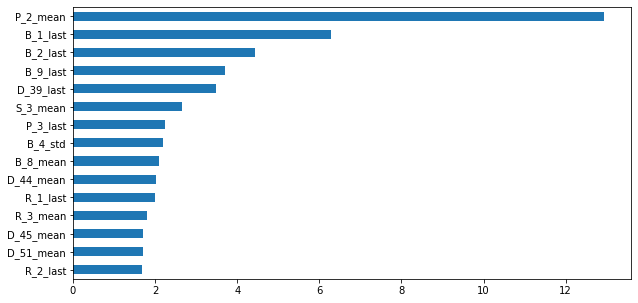

In [ ]:
feature_imp_cat = pd.Series(clf.feature_importances_, index=X.columns)
feature_imp_cat.nlargest(15).sort_values(ascending=True).plot(kind='barh',
                                                              figsize=(10, 5));

## CatBoost + CV

In [ ]:
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts = np.empty(N_FOLDS)
preds_lst = []
preds_prob_lst = []
models_ls = []

for idx, (train_idx,
          valid_idx) in tqdm_notebook(enumerate(cv.split(X_train, y_train)),
                                      total=N_FOLDS):
    X_train_, X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_train_, y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    model = CatBoostClassifier(
        random_state=RAND,
        # eval_metric=Amex_metric_cat(),
        cat_features=cat_features,
        task_type='GPU')
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_valid, y_valid)],
              verbose=False,
              early_stopping_rounds=200)

    models_ls.append(model)
    preds_lst.append(model.predict(X_test))
    preds_prob_lst.append(model.predict_proba(X_test)[:, 1])

metric_df = pd.concat([
    metric_df,
    get_metrics(y_test,
                stats.mode(preds_lst)[0][0], np.mean(preds_prob_lst, axis=0),
                'CatBoost + 5CV')
],
                      ignore_index=True)

metric_df.style.highlight_max(color='yellowgreen', subset='AMEX')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/5 [00:00<?, ?it/s]

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,AMEX
0,Lightgbm Base,0.878540,0.957980,0.702367,0.921358,0.797095,0.265844,0.777343
1,LGBM + 5CV,0.878986,0.958443,0.703645,0.920222,0.797491,0.264077,0.780079
2,LGBM_CV + Optuna,0.881176,0.959166,0.708482,0.919423,0.800286,0.261746,0.782274
3,Catboost Base,0.901768,0.959220,0.812712,0.806488,0.809588,0.223845,0.786431
4,CatBoost + 5CV,0.901627,0.959224,0.812529,0.806067,0.809285,0.223883,0.786666


In [ ]:
preds_train, preds_test = cv_predict(models_ls, X_train, X_test)
check_overfitting(*preds_train, *preds_test, y_test, y_train)

Проверка на overfitting
--------------------
F1 score train: 0.822
F1 score test: 0.808
--------------------
Recall score train: 0.817
Recall score test: 0.805
--------------------
Amex score train: 0.807
Amex score test: 0.786


## CatBoost + Optuna

In [ ]:
def objective(trial):
    params = {
        # 'max_depth': trial.suggest_int('max_depth', 3, 16),
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
        'n_estimators': trial.suggest_categorical("n_estimators", [1000]),
        # 'max_bin': trial.suggest_int('max_bin', 200, 400),
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log=True),
        # 'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'random_seed': RAND,
        'loss_function': 'Logloss',
        'eval_metric': Amex_metric_cat(),
        # 'task_type': 'GPU',
        # 'bootstrap_type': 'Poisson',
        'cat_features': cat_features
    }
    
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
    cv_predicts = np.empty(N_FOLDS)
    
    for idx, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_train)):
        X_train_, X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_train_, y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = CatBoostClassifier(**params)
        model.fit(X_train_,
                  y_train_,
                  eval_set=[(X_valid, y_valid)],
                  early_stopping_rounds=200, 
                  verbose=False)

        preds_prob = model.predict_proba(X_test)[:, 1]
        cv_predicts[idx] = amex_metric(y_test, preds_prob)

    return np.mean(cv_predicts)
    

study_cat = optuna.create_study(
    direction = 'maximize', study_name="CatBoost Classifier")
study_cat.optimize(objective, n_trials=5)
print('Best value:', study_cat.best_value)

In [ ]:
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts = np.empty(N_FOLDS)
preds_lst = []
preds_prob_lst = []
models_ls = []

for idx, (train_idx, valid_idx) in tqdm_notebook(enumerate(cv.split(X_train, y_train)), total=N_FOLDS):
    X_train_, X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    y_train_, y_valid = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    model = CatBoostClassifier(**study_cat.best_params, cat_features=cat_features,
                         task_type='GPU', bootstrap_type='Poisson')
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_valid, y_valid)],
              early_stopping_rounds=200, 
              verbose = False)
    
    models_ls.append(model)
    preds_lst.append(model.predict(X_test))
    preds_prob_lst.append(model.predict_proba(X_test)[:, 1])


metric_df = pd.concat([metric_df, get_metrics(
    y_test, stats.mode(preds_lst)[0][0], 
    np.mean(preds_prob_lst, axis=0), 'Catboost_CV + Optuna')
], ignore_index=True)

metric_df.style.highlight_max(color='yellowgreen', subset='AMEX')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/5 [00:00<?, ?it/s]

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,AMEX
0,Lightgbm Base,0.878540,0.957980,0.702367,0.921358,0.797095,0.265844,0.777343
1,LGBM + 5CV,0.878986,0.958443,0.703645,0.920222,0.797491,0.264077,0.780079
2,LGBM_CV + Optuna,0.881176,0.959166,0.708482,0.919423,0.800286,0.261746,0.782274
3,Catboost Base,0.901768,0.959220,0.812712,0.806488,0.809588,0.223845,0.786431
4,CatBoost + 5CV,0.901627,0.959224,0.812529,0.806067,0.809285,0.223883,0.786666
5,Catboost_CV + Optuna,0.898554,0.957472,0.806653,0.799966,0.803296,0.228886,0.779718


In [ ]:
preds_train, preds_test = cv_predict(models_ls, X_train, X_test)
check_overfitting(*preds_train, *preds_test, y_test, y_train)

Проверка на overfitting
--------------------
F1 score train: 0.808
F1 score test: 0.803
--------------------
Recall score train: 0.803
Recall score test: 0.799
--------------------
Amex score train: 0.786
Amex score test: 0.778


## Stacking

In [ ]:
class StackingClassifierOwn(BaseEstimator, ClassifierMixin):
    def __init__(self, models, ens_model, cat_feat, cv: int = 3):
        """
        models - базовые модели для стекинга
        ens_model - мета-модель
        cv - кол-во фолдов
        """
        self.models = models
        self.ens_model = ens_model
        self.cv = cv
        self.cat_feat = cat_feat

    def crossval_predict(self, model, X: pd.DataFrame, y: pd.Series) -> np.array:
        """
        Получение новых мета-признаков при помощи кросс-валидации
        """
        folds = StratifiedKFold(n_splits=self.cv)
        predicts = []

        for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            if model.__class__.__name__ == 'LGBMClassifier':
                model.fit(X_train,
                          y_train,
                          eval_metric=lgb_amex_metric,
                          eval_set=[(X_test, y_test)]
                          )
            elif model.__class__.__name__ == 'CatBoostClassifier':
                train_data = Pool(data=X_train,
                                  label=y_train,
                                  cat_features=self.cat_feat)
                eval_data = Pool(data=X_test,
                                 label=y_test,
                                 cat_features=self.cat_feat)
                model.fit(train_data,
                          eval_set=eval_data,
                          use_best_model=True, 
                          verbose=False,
                          early_stopping_rounds=200)
            else:
                model.fit(X_train, y_train)
            y_predict_val = model.predict_proba(X_test)[:,1]
            predicts.append(y_predict_val)
        return np.concatenate(predicts)

    def fit(self, X: pd.DataFrame, y: pd.Series, X_bin: pd.DataFrame):
        """
        Обучение ансамбля моделей в зависимости от самой модели и данных 
        (бинаризованные, категориальые)
        """
        meta_X = list()
        for model in tqdm_notebook(self.models):
            # обучение на категориальных данных
            if model.__class__.__name__ in [
                    'LGBMClassifier', 'CatBoostClassifier'
            ]:
                yhat = self.crossval_predict(model=model, X=X, y=y)
                yhat = yhat.reshape(len(yhat), 1)
                meta_X.append(yhat)
                
                # настройка модели для предсказания на test
                if model.__class__.__name__ == 'CatBoostClassifier':
                    model.fit(X, y, cat_features=self.cat_feat, 
                              use_best_model=True, silent=True)
                else:
                    model.fit(X, y)
            # обучение на бинаризованных данных
            else:
                yhat = self.crossval_predict(model=model, X=X_bin, y=y)
                yhat = yhat.reshape(len(yhat), 1)
                meta_X.append(yhat)
                model.fit(X_bin, y)
                
        meta_X = np.hstack(meta_X)
        self.ens_model.fit(meta_X, y)

        return self

    def predict(self, X: pd.DataFrame, X_bin: pd.DataFrame) -> np.array:
        """
        Получение прогнозов - классов
        """
        meta_X = list()
        for model in self.models:
            if model.__class__.__name__ in [
                    'LGBMClassifier', 'CatBoostClassifier'
            ]:
                # ответы на тестовой выборке
                yhat = model.predict(X)
            else:
                yhat = model.predict(X_bin)
            yhat = yhat.reshape(len(yhat), 1)
            meta_X.append(yhat)
        meta_X = np.hstack(meta_X)

        return self.ens_model.predict(meta_X)

    def predict_proba(self, X: pd.DataFrame, X_bin: pd.DataFrame) -> np.array:
        """
        Получение прогнозов - вероятностей
        """
        meta_X = list()
        for model in self.models:
            if model.__class__.__name__ in [
                    'LGBMClassifier', 'CatBoostClassifier'
            ]:
                # ответы на тестовой выборке
                yhat = model.predict(X)
            else:
                yhat = model.predict(X_bin)
            yhat = yhat.reshape(len(yhat), 1)
            meta_X.append(yhat)
        meta_X = np.hstack(meta_X)

        return self.ens_model.predict_proba(meta_X)

In [ ]:
# Объявляем базоыве алгоритмы
clf_01 = LGBMClassifier(**study_lgb.best_params,
                        random_state=RAND,
                        verbose=-1, is_unbalance=True)
clf_02 = LGBMClassifier(**study_lgb.best_params,
                        random_state=RAND+1,
                        verbose=-1, is_unbalance=True)
clf_03 = CatBoostClassifier(
    random_state=RAND,
    # eval_metric=Amex_metric_cat(),
    cat_features=cat_features,
    task_type='GPU',
    bootstrap_type='Poisson')

models = [clf_01, clf_02, clf_03]
stack_model = LogisticRegression(random_state=RAND)

# Бинаризованные тренировочные данные
X_train_bin = pd.DataFrame(transformed.transform(X_train),
                           columns=transformer.get_feature_names_out())
# Обучение
stack = StackingClassifierOwn(models, stack_model, cat_features, cv=5)
stack.fit(X_train, y_train, X_train_bin)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

You should provide test set for use best model. use_best_model parameter has been switched to false value.


StackingClassifierOwn(cat_feat=['D_63_count', 'D_63_last', 'D_63_nunique',
                                'D_64_count', 'D_64_last', 'D_64_nunique',
                                'D_68_count', 'D_68_last', 'D_68_nunique',
                                'B_30_count', 'B_30_last', 'B_30_nunique',
                                'B_38_count', 'B_38_last', 'B_38_nunique',
                                'D_114_count', 'D_114_last', 'D_114_nunique',
                                'D_116_count', 'D_116_last', 'D_116_nunique',
                                'D_117_count', 'D_117_last', 'D_11...
                                             bagging_freq=1, device_type='gpu',
                                             feature_fraction=0.6000000000000001,
                                             is_unbalance=True, lambda_l1=30,
                                             lambda_l2=100,
                                             learning_rate=0.03577217547987923,
                   

In [ ]:
# Бинаризованные тестовые данные
X_test_bin = pd.DataFrame(transformed.transform(X_train), 
                          columns=transformer.get_feature_names_out())

preds_test = stack.predict(X_test, X_test_bin)
preds_prob_test = stack.predict_proba(X_test, X_test_bin)[:,1]
preds_train = stack.predict(X_train, X_train_bin)
preds_prob_train = stack.predict_proba(X_train, X_train_bin)[:,1]

metric_df = pd.concat([
    metric_df, get_metrics(y_test, preds_test, preds_prob_test, 'Stacking'
    )], 
    ignore_index=True)

metric_df.style.highlight_max(color='yellowgreen', subset='AMEX')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,AMEX
0,Lightgbm Base,0.878540,0.957980,0.702367,0.921358,0.797095,0.265844,0.777343
1,LGBM + 5CV,0.878986,0.958443,0.703645,0.920222,0.797491,0.264077,0.780079
2,LGBM_CV + Optuna,0.881176,0.959166,0.708482,0.919423,0.800286,0.261746,0.782274
3,Catboost Base,0.901768,0.959220,0.812712,0.806488,0.809588,0.223845,0.786431
4,CatBoost + 5CV,0.901627,0.959224,0.812529,0.806067,0.809285,0.223883,0.786666
5,Catboost_CV + Optuna,0.898554,0.957472,0.806653,0.799966,0.803296,0.228886,0.779718
6,Stacking,0.900820,0.918865,0.810696,0.804931,0.807804,0.293321,0.624598


In [ ]:
check_overfitting(preds_train, preds_prob_train, preds_test, preds_prob_test, 
                  y_test, y_train)


Проверка на overfitting
--------------------
F1 score train: 0.815
F1 score test: 0.808
--------------------
Recall score train: 0.810
Recall score test: 0.805
--------------------
Amex score train: 0.641
Amex score test: 0.625


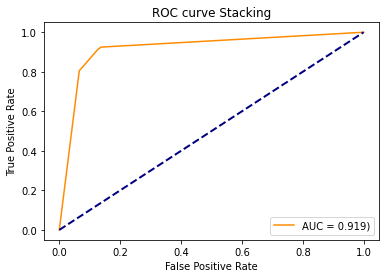

In [ ]:
# Построение ROC-AUC кривой
fpr, tpr, thresholds = roc_curve(y_test, preds_prob_test)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Stacking')

plt.legend()
plt.show()

## Voting Classifier

In [ ]:
lg = LGBMClassifier(**study_lgb.best_params, 
                    is_unbalance=True, 
                    device='gpu', 
                    verbose=-1)
clb_lg = CalibratedClassifierCV(base_estimator=lg, cv=5)
                           
cat = CatBoostClassifier(
    random_state=RAND,
    verbose=0,
    # eval_metric=Amex_metric_cat(),
    cat_features=cat_features,
    task_type='GPU')
clb_cat = CalibratedClassifierCV(base_estimator=cat, cv=5)

In [ ]:
w = [0.5, 0.5]
models = [clb_cat, clb_lg]

vt_clf = VotingClassifier(estimators=[('cat', clb_cat), ('lg', clb_lg)],
                          voting='soft', weights=w)

vt_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('cat',
                              CalibratedClassifierCV(base_estimator=<catboost.core.CatBoostClassifier object at 0x7f4f06eb2290>,
                                                     cv=5)),
                             ('lg',
                              CalibratedClassifierCV(base_estimator=LGBMClassifier(bagging_fraction=0.5,
                                                                                   bagging_freq=1,
                                                                                   device='gpu',
                                                                                   device_type='gpu',
                                                                                   feature_fraction=0.6000000000000001,
                                                                                   is_unbalance=True,
                                                                                   lambda_l1=30,
               

In [ ]:
preds_test = vt_clf.predict(X_test)
preds_prob_test = vt_clf.predict_proba(X_test)[:, 1]
preds_train = vt_clf.predict(X_train)
preds_prob_train = vt_clf.predict_proba(X_train)[:, 1]

metric_df = pd.concat([
    metric_df,
    get_metrics(y_test, preds_test, preds_prob_test, 'Voting Classifier')
],
                      ignore_index=True)

metric_df.style.highlight_max(color='yellowgreen', subset='AMEX')

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss,AMEX
0,Lightgbm Base,0.878540,0.957980,0.702367,0.921358,0.797095,0.265844,0.777343
1,LGBM + 5CV,0.878986,0.958443,0.703645,0.920222,0.797491,0.264077,0.780079
2,LGBM_CV + Optuna,0.881176,0.959166,0.708482,0.919423,0.800286,0.261746,0.782274
3,Catboost Base,0.901768,0.959220,0.812712,0.806488,0.809588,0.223845,0.786431
4,CatBoost + 5CV,0.901627,0.959224,0.812529,0.806067,0.809285,0.223883,0.786666
5,Catboost_CV + Optuna,0.898554,0.957472,0.806653,0.799966,0.803296,0.228886,0.779718
6,Stacking,0.900820,0.918865,0.810696,0.804931,0.807804,0.293321,0.624598
7,Voting Classifier,0.900897,0.959235,0.802749,0.818354,0.810476,0.235487,0.784910


In [ ]:
check_overfitting(preds_train, preds_prob_train, preds_test, preds_prob_test, 
                  y_test, y_train)

Проверка на overfitting
--------------------
F1 score train: 0.819
F1 score test: 0.810
--------------------
Recall score train: 0.825
Recall score test: 0.818
--------------------
Amex score train: 0.798
Amex score test: 0.785


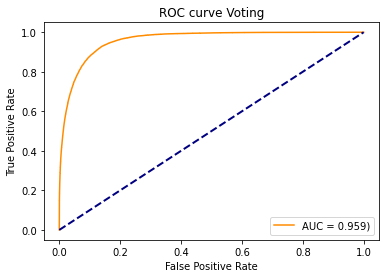

In [ ]:
# Построение ROC-AUC кривой
fpr, tpr, thresholds = roc_curve(y_test, preds_prob_test)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {round(roc_auc,3)})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Voting')

plt.legend()
plt.show()

## Выбор лучшей модели

Выбор лучшей модель и её обучение на полном тренировочном датасете

In [ ]:
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)
cv_predicts = np.empty(N_FOLDS)
models_ls = []

for idx, (train_idx,
          valid_idx) in tqdm_notebook(enumerate(cv.split(X, y)),
                                      total=N_FOLDS):
    X_train_, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train_, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = CatBoostClassifier(
        random_state=RAND,
        # eval_metric=Amex_metric_cat(),
        cat_features=cat_features,
        task_type='GPU')
    model.fit(X_train_,
              y_train_,
              eval_set=[(X_valid, y_valid)],
              verbose=False,
              early_stopping_rounds=200)

    models_ls.append(model)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# Удаление данных для освобождения памяти
del X, y, X_train_bin, X_test_bin, X_train, y_train, X_test, y_test
gc.collect()

35

# Предсказание тестовых данных

In [ ]:
# Загрузка тестовых данных(данные для предсказания)
test_df = pd.read_feather('/content/drive/MyDrive/Colab Notebooks/Pet project/test_data_prep.ftr')
print('Количество уникальных ID:', test_df['customer_ID'].unique().shape[0])

Количество уникальных ID: 406811


In [ ]:
# Уникальные ID клиентов и их количество
uniq_ID = test_df['customer_ID'].unique()
uniq_len = uniq_ID.shape[0]

# Разделяю одну воборку на несколько маленьких
step = uniq_len // 20
# Датафрейм для предсказанных значений
submis = pd.DataFrame({'customer_ID': pd.Series(dtype='object'),
                   'prediction': pd.Series(dtype='int64')})

for i in tqdm_notebook(range(0, uniq_len, step)):
    part_test_df = test_df[test_df['customer_ID'].isin(uniq_ID[i: i+step])]

#   Предсказание новых данных
    customer_ID = part_test_df['customer_ID']
    X_test = part_test_df.drop(['customer_ID'], axis=1)
    
    predict_ls = [model.predict(X_test) for model in models_ls]

    preds = pd.DataFrame({'customer_ID': pd.Series(customer_ID), 
                        'prediction': pd.Series(stats.mode(predict_ls)[0][0])})
    submis = pd.concat([submis, preds], axis=0, ignore_index=True)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
submis.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.0
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.0
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.0
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.0
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.0


In [ ]:
submis.to_csv('submission.csv', index=False)